In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
# IMPORT SPARK

In [3]:
# Создать сессию

In [ ]:
df = spark.read.option('inferSchema', True).csv('Life_Expectancy.csv', header=True)
df.show(2)

# как отразить таблицу лучше

In [12]:
# пример в Pandas ! (но лучше так не делать)
df.limit(5).toPandas()

Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0              263   
1  Afghanistan  2014  Developing              59.9              271   
2  Afghanistan  2013  Developing              59.9              268   
3  Afghanistan  2012  Developing              59.5              272   
4  Afghanistan  2011  Developing              59.2              275   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624           65      1154  ...   
1             64     0.01               73.523582           62       492  ...   
2             66     0.01               73.219243           64       430  ...   
3             69     0.01               78.184215           67      2787  ...   
4             71     0.01                7.097109           68      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0      6               8.16           65        0.1  584.259210  33736494.0   
1     58               8.18           62        0.1  612.696514    327582.0   
2     62               8.13           64        0.1  631.744976  31731688.0   
3     67               8.52           67        0.1  669.959000   3696958.0   
4     68               7.87           68        0.1   63.537231   2978599.0   

    thinness  1-19 years   thinness 5-9 years  \
0                   17.2                 17.3   
1                   17.5                 17.5   
2                   17.7                 17.7   
3                   17.9                 18.0   
4                   18.2                 18.2   

   Income composition of resources  Schooling  
0                            0.479       10.1  
1                            0.476       10.0  
2                            0.470        9.9  
3                            0.463        9.8  
4                            0.454        9.5  

[5 rows x 22 columns]

In [13]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Life expectancy : double (nullable = true)
 |-- Adult Mortality: integer (nullable = true)
 |-- infant deaths: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- percentage expenditure: double (nullable = true)
 |-- Hepatitis B: integer (nullable = true)
 |-- Measles : integer (nullable = true)
 |--  BMI : double (nullable = true)
 |-- under-five deaths : integer (nullable = true)
 |-- Polio: integer (nullable = true)
 |-- Total expenditure: double (nullable = true)
 |-- Diphtheria : integer (nullable = true)
 |--  HIV/AIDS: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Population: double (nullable = true)
 |--  thinness  1-19 years: double (nullable = true)
 |--  thinness 5-9 years: double (nullable = true)
 |-- Income composition of resources: double (nullable = true)
 |-- Schooling: double (nullable = true)



In [14]:
df = df.select('Country', 'Year', 'Alcohol', 'GDP', 'Population')

In [15]:
df.show(3)

+-----------+----+-------+----------+-----------+
|    Country|Year|Alcohol|       GDP| Population|
+-----------+----+-------+----------+-----------+
|Afghanistan|2015|   0.01| 584.25921|3.3736494E7|
|Afghanistan|2014|   0.01|612.696514|   327582.0|
|Afghanistan|2013|   0.01|631.744976|3.1731688E7|
+-----------+----+-------+----------+-----------+
only showing top 3 rows



## Histogram 

Визуализировать проще черезе Spark RDD (.histogram())

In [20]:
def histogram(df, col, bins=10, xname=None, yname=None):

    # расчет в Spark 
    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)
    
    # препроцессинг визуализации  
    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]
    
    # визуализация
    plt.bar(loc, vals[1], width=width)
    plt.xlabel(col)
    plt.ylabel(yname)
    plt.show()

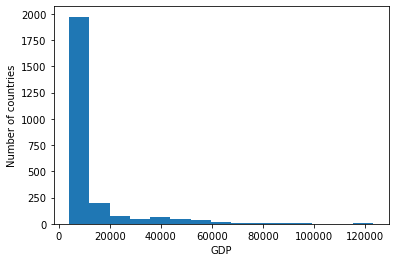

In [22]:
# визуализируем
histogram(df, 'GDP', bins=15, yname='Number of countries')

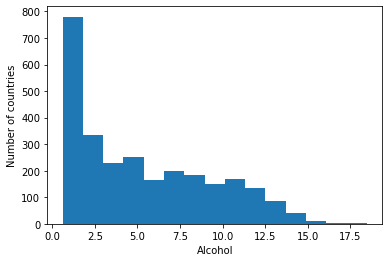

In [23]:
histogram(df, 'Alcohol', bins=15, yname='Number of countries')

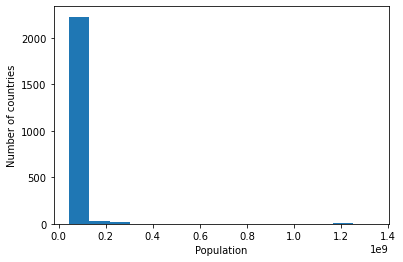

In [45]:
histogram(df, 'Population', bins=15, yname='Number of countries')

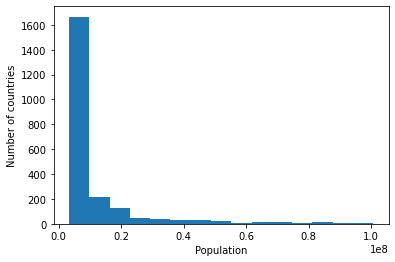

In [43]:
# даже с передачей фильтрованного DF работает
histogram(df.filter(df['Population']<100000000),
          'Population',
          bins=15,
          yname='Number of countries')

## Line plot 

In [47]:
def lineplot(df, x, y, measure='mean'):
    
    
    if measure == 'mean':
        
        # Группируем по x и среднее по y       
        pd_df = df.groupBy(x).mean(y).toPandas().sort_values(by=x)
        
        # обыная визуализация, как в Pandas
        pd_df.plot(x, 'avg({})'.format(y), legend=False)
        
    elif measure == 'total':
        pd_df = df.groupBy(x).sum(y).toPandas().sort_values(by=x)
        pd_df.plot(x, 'sum({})'.format(y), legend=False)
        
    elif measure == 'count':
        pd_df = df.groupBy(x).count().toPandas().sort_values(by=x)
        pd_df.plot(x, 'count', legend=False)
    
    plt.ylabel(y)
    plt.show()

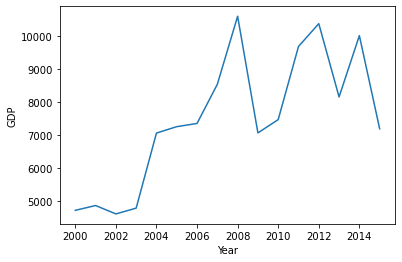

In [66]:
lineplot(df, 'Year', 'GDP', measure='mean')

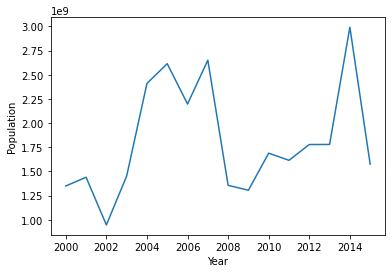

In [50]:
lineplot(df, 'Year', 'Population', measure='total')

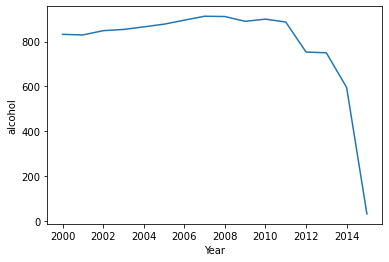

In [65]:
# The world has become no alcoholic all of sudden??!

lineplot(df, 'Year', 'alcohol', measure='total')

# Bar plot 

In [55]:
def barplot(df, col, lim=10, yname=None):
    

    
    # Группировка по категориям, расчет значений по каждой категории 
    # Устанавливаем последовательность от большего
    classes = df.groupBy(col).count().orderBy('count', ascending=False)
    
    # Берем только лимитированное кол-во столбцов (результатов)
    pd_df = classes.limit(lim).toPandas()
    
    # Визуализируем
    pd_df.plot(kind='bar', x=col, legend=False)
    plt.ylabel(yname)
    plt.show()

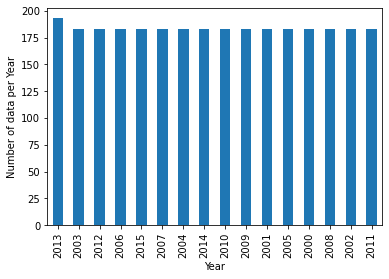

In [69]:
#применяем
barplot(df, 'Year', lim=20, yname='Number of data per Year')

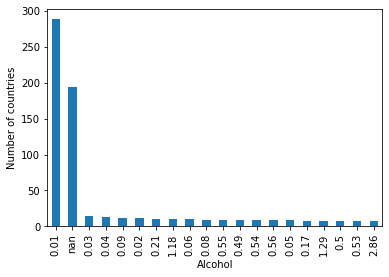

In [58]:
barplot(df, 'Alcohol', lim=20, yname='Number of countries')

# Pie chart 

In [70]:
def pieplot(df, col, lim=10, yname=None):
    
    # Группировка по категориям, расчет значений по каждой категории 
    # Устанавливаем последовательность от большего
    classes = df.groupBy(col).count().orderBy('count', ascending=False)
    
    # Берем только лимитированное кол-во столбцов (результатов)
    pd_df = classes.limit(lim).toPandas()
    
    # виз
    pd_df.plot(kind='pie', x=col, y='count', \
           labels=pd_df[col], legend=False)
    plt.ylabel(None)
    plt.show()

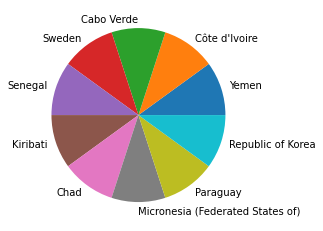

In [71]:
pieplot(df, 'Country')

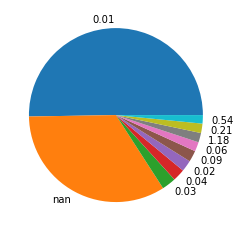

In [73]:
pieplot(df, 'Alcohol')

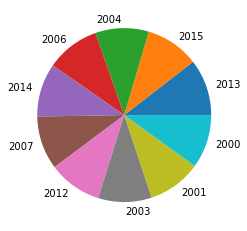

In [77]:
pieplot(df, 'Year')

# Box plot 

In [74]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [75]:
def boxplot(df, col, group_by, samp_size=10000): 

    
    # Берем сэмпл от всего Df    
    true_samp_size = min(samp_size/df.count(), 1.0)
    pd_df = df.sample(False, true_samp_size).toPandas()
    
    # визуализируем на основе сэмпла
    pd_df.boxplot(col, by=group_by, figsize=(8, 5))
    plt.ylabel(col)
    plt.title(None)
    plt.show()

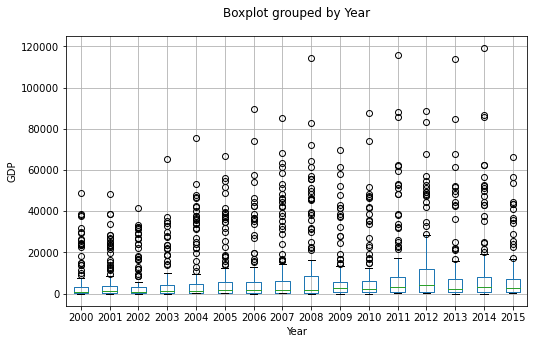

In [76]:
boxplot(df, 'GDP', 'Year')

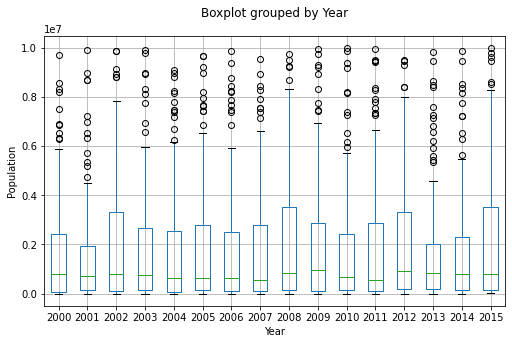

In [81]:
boxplot(df.filter(df['Population']<10000000), 'Population', 'Year')